<a href="https://colab.research.google.com/github/simoneseverini/automated-discovery-site/blob/main/Markov_Fibonacci_drawing_Dec_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Search] Exploring Markov Tree (Limit: 1500 nodes)...


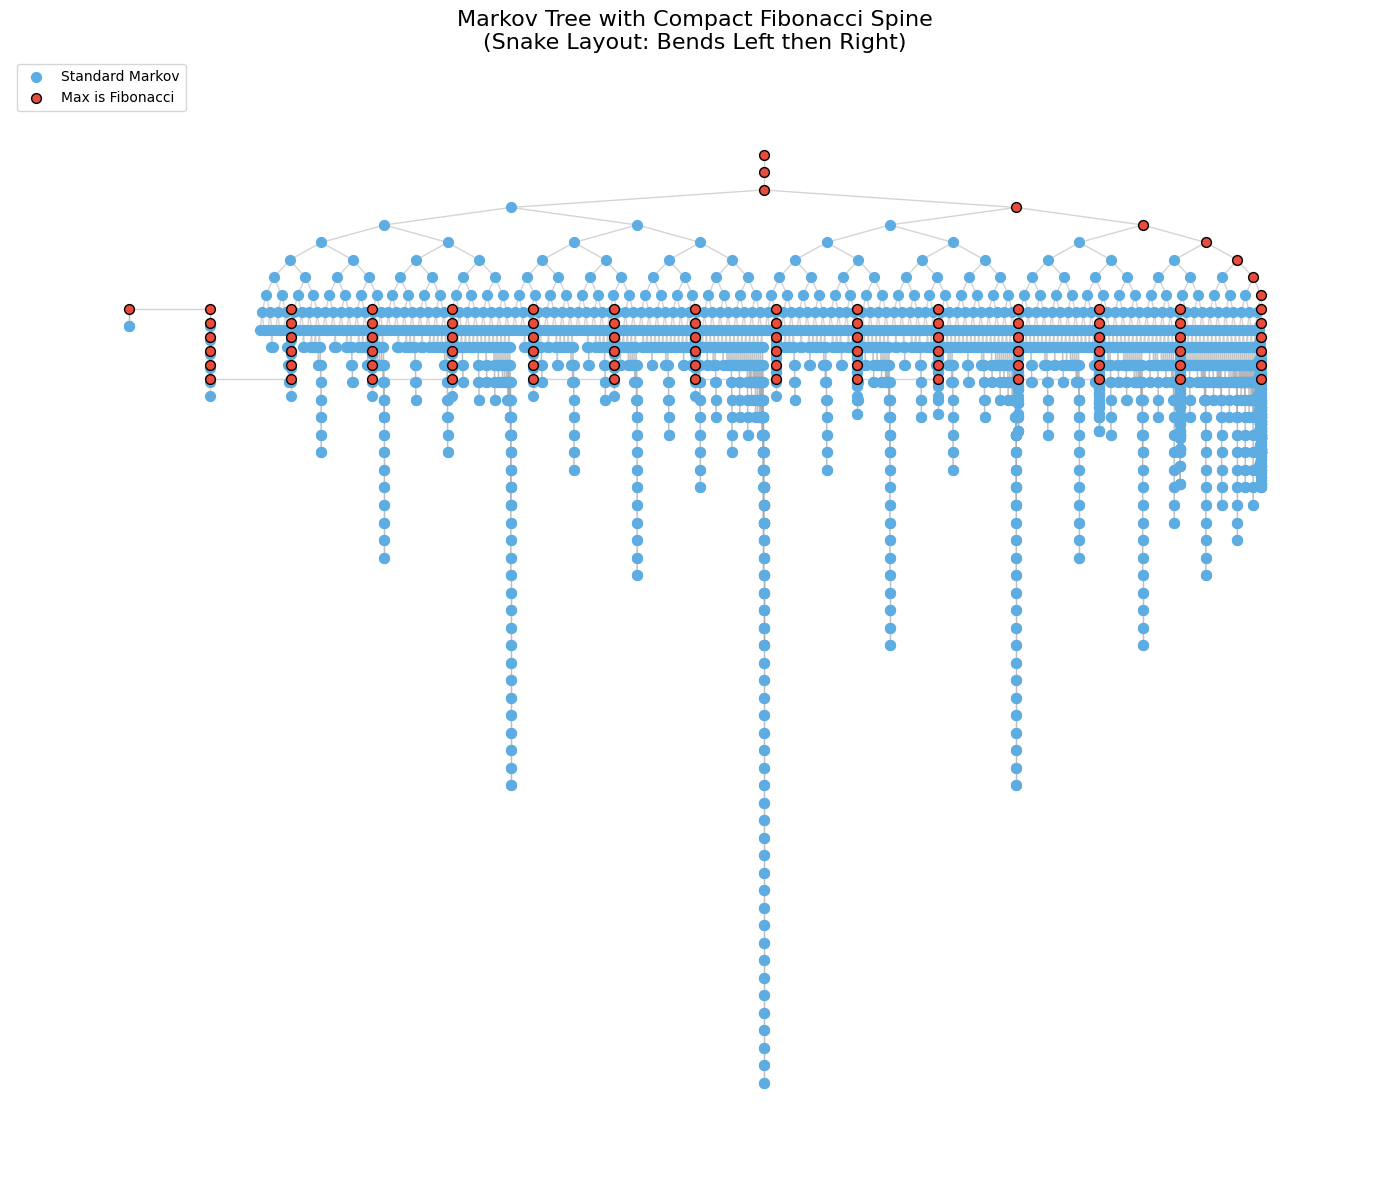


First 15 Fibonacci-Markov Triples:
1: (1, 1, 1)
2: (1, 1, 2)
3: (1, 2, 5)
4: (1, 5, 13)
5: (1, 13, 34)
6: (1, 34, 89)
7: (1, 89, 233)
8: (1, 233, 610)
9: (1, 610, 1597)
10: (1, 1597, 4181)
11: (1, 4181, 10946)
12: (1, 10946, 28657)
13: (1, 28657, 75025)
14: (1, 75025, 196418)
15: (1, 196418, 514229)
16: (1, 514229, 1346269)
17: (1, 1346269, 3524578)


In [6]:
# @title Markov-Fibonacci Explorer (Compact Snake Layout)
# @markdown This script finds Markov triples, generates the Fibonacci branch, and visualizes the tree.
# @markdown **Feature:** The layout "bends" the long Fibonacci tail into a compact snake pattern to avoid deep vertical rays.

import networkx as nx
import matplotlib.pyplot as plt
import heapq
import math
import sys
import collections

# Increase integer string limit for huge numbers
sys.set_int_max_str_digits(1000000)

# ==========================================
# 1. Mathematical Helpers
# ==========================================

def is_perfect_square(n):
    if n < 0: return False
    if n == 0: return True
    sqrt_n = math.isqrt(n)
    return sqrt_n * sqrt_n == n

def is_fibonacci(n):
    """Checks if n is a Fibonacci number."""
    if n < 0: return False
    if n <= 3: return True
    # Gessel's test: 5n^2 +/- 4 is a square
    return is_perfect_square(5*n*n + 4) or is_perfect_square(5*n*n - 4)

# ==========================================
# 2. Tree Search & Generation
# ==========================================

def solve_markov_search(limit_nodes=2000):
    """
    Explores the Markov tree to build the graph structure.
    Returns: Graph G, List of Fibonacci Triples, and the 'Spine' path.
    """
    print(f"[Search] Exploring Markov Tree (Limit: {limit_nodes} nodes)...")

    # Priority Queue: (max_val, x, y, z)
    pq = [(1, 1, 1, 1)]
    visited = set([(1, 1, 1)])

    # We use a DiGraph to easily track children for layout
    G = nx.DiGraph()
    G.add_node((1,1,1), is_fib=True, layer=0)

    fib_found = []

    # Dictionary to track parent pointers for spine reconstruction
    parents = {(1,1,1): None}

    count = 0
    while pq and count < limit_nodes:
        max_val, x, y, z = heapq.heappop(pq)
        curr = (x, y, z)
        current_layer = G.nodes[curr].get('layer', 0)

        # Track Fibs
        if is_fibonacci(z):
            if curr not in fib_found:
                fib_found.append(curr)

        # Determine neighbors (Expansion)
        neighbors = []

        # 1. Flip x -> (3yz - x, y, z)
        nx_val = 3*y*z - x
        neighbors.append(tuple(sorted((nx_val, y, z))))

        # 2. Flip y -> (x, 3xz - y, z)
        ny_val = 3*x*z - y
        neighbors.append(tuple(sorted((x, ny_val, z))))

        # 3. Root special case
        if curr == (1, 1, 1):
             neighbors.append((1, 1, 2))

        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                parents[nb] = curr

                is_nb_fib = is_fibonacci(nb[2])

                # Add node with layer info
                G.add_node(nb, is_fib=is_nb_fib, layer=current_layer + 1)
                G.add_edge(curr, nb)

                heapq.heappush(pq, (nb[2], nb[0], nb[1], nb[2]))

        count += 1

    return G, fib_found

def generate_large_fib_branch(n_terms=300):
    """Generates the main Fibonacci branch analytically."""
    results = [(1, 1, 1), (1, 1, 2)]
    u, v = 1, 2
    for _ in range(n_terms):
        w = 3*v - u
        results.append((1, v, w))
        u, v = v, w
    return results

# ==========================================
# 3. Layout Algorithms
# ==========================================

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    """
    Standard Reingold-Tilford (Level-Based) Layout.
    """
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    if pos is None: pos = {root:(xcenter,vert_loc)}
    else: pos[root] = (xcenter, vert_loc)

    children = list(G.successors(root))
    if len(children)!=0:
        dx = width/len(children)
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                           vert_loc = vert_loc-vert_gap, xcenter=nextx,
                           pos=pos, parent = root)
    return pos

def apply_snake_folding(G, pos, fib_nodes, bend_depth=8, col_height=5, spacing=0.15):
    """
    Modifies the layout 'pos' in place.
    Identifies the Fibonacci Spine and wraps it into a snake pattern
    (Down -> Left -> Up -> Left -> Down...) starting at 'bend_depth'.
    """
    # 1. Identify the spine (The path of Fibonacci nodes)
    # We sort them by layer (depth)
    spine = sorted([n for n in fib_nodes if n in pos], key=lambda x: G.nodes[x].get('layer', 0))

    # Parameters for the snake
    # We detect the 'bend point' coordinates
    if len(spine) <= bend_depth:
        return pos # No modification needed

    # Get the position of the node just before bending
    bend_node = spine[bend_depth-1]
    start_x, start_y = pos[bend_node]

    # Defines the snake columns
    # We will move LEFT from the start_x

    for i, node in enumerate(spine[bend_depth:]):
        # Index in the folded tail
        idx = i

        # Determine Column and Row in the snake
        col_idx = idx // col_height
        row_idx = idx % col_height

        # Calculate base position for the spine node
        # X: Shifts Left every column
        new_x = start_x - (col_idx * spacing)

        # Y: Alternates Up and Down
        # Even columns (0, 2..): Go Down
        # Odd columns (1, 3..): Go Up
        if col_idx % 2 == 0:
            # Downwards from start_y
            new_y = start_y - ((row_idx + 1) * spacing) # +1 to step down from the bend node
        else:
            # Upwards from the bottom of the previous column
            # The previous column ended at: start_y - (col_height * spacing)
            # We want to go UP.
            bottom_y = start_y - (col_height * spacing)
            new_y = bottom_y + (row_idx * spacing)

        # Apply shift to the spine node
        old_x, old_y = pos[node]
        shift_x = new_x - old_x
        shift_y = new_y - old_y

        pos[node] = (new_x, new_y)

        # IMPORTANT: Also shift any children (side branches) of this node
        # so they stay attached to the spine.
        # We do a BFS/DFS from this node to finding all descendants in the visual tree
        descendants = descendants_in_tree(G, node, spine)
        for desc in descendants:
            dx, dy = pos[desc]
            pos[desc] = (dx + shift_x, dy + shift_y)

    return pos

def descendants_in_tree(G, root, exclude_list):
    """Finds all descendants of root excluding specific nodes (the spine itself)."""
    desc = []
    stack = [root]
    exclude_set = set(exclude_list)
    while stack:
        curr = stack.pop()
        children = list(G.successors(curr))
        for child in children:
            if child not in exclude_set:
                desc.append(child)
                stack.append(child)
    return desc

# ==========================================
# 4. Main Execution
# ==========================================

# 1. Search
G, search_fibs = solve_markov_search(limit_nodes=1500)

# 2. Initial Layout (Reingold-Tilford)
# This gives us a nice tree structure, but the fib branch shoots deep down.
pos = hierarchy_pos(G, root=(1,1,1), width=5.0, vert_gap=0.5)

# 3. Apply Snake Folding
# This bends the Fibonacci tail to the left and snakes it to avoid infinite depth.
# We start bending at depth 8.
pos = apply_snake_folding(G, pos, search_fibs, bend_depth=9, col_height=6, spacing=0.4)

# 4. Visualization
plt.figure(figsize=(14, 12))

# Separate nodes for styling
fib_nodes_set = set(search_fibs)
std_nodes = [n for n in G.nodes() if n not in fib_nodes_set]
fib_nodes = [n for n in G.nodes() if n in fib_nodes_set]

# Draw Edges (Straight lines, "Angles all at the same point")
nx.draw_networkx_edges(G, pos, edge_color='#AAAAAA', alpha=0.5, arrows=False)

# Draw Standard Nodes (Blue)
nx.draw_networkx_nodes(G, pos, nodelist=std_nodes, node_color='#5DADE2', node_size=50, label='Standard Markov')

# Draw Fibonacci Nodes (Red) - Same size as others
nx.draw_networkx_nodes(G, pos, nodelist=fib_nodes, node_color='#E74C3C', node_size=50, edgecolors='black', label='Max is Fibonacci')

# Labels: No labels as requested
# But we can add a few annotation for context if needed, or leave blank.
# We will add a title and legend.

plt.title("Markov Tree with Compact Fibonacci Spine\n(Snake Layout: Bends Left then Right)", fontsize=16)
plt.legend(loc="upper left")
plt.axis('off')
plt.tight_layout()
plt.show()

# Verification Stats
large_fibs = generate_large_fib_branch(n_terms=15)
print("\nFirst 15 Fibonacci-Markov Triples:")
for i, t in enumerate(large_fibs):
    print(f"{i+1}: {t}")

[Search] exploring first 1000 nodes of the Markov tree...
[Search] Completed in 0.0318 seconds.
[Generator] Calculating 500 sequential Fibonacci-Markov triples...

--- Results ---
Total Fibonacci Triples found in search: 77
Largest number found in search: 42230279526998466217810220532898
Largest number generated analytically: (See below)
The 500th triple has a max number with 210 digits.
Triple: (1, 70330367711422815821835254877183549770181269836358732742604905087154537118196933579742249494562611733487750449241765991088186363265450223647106012053374121273867339111198139373125598767690091902245245323403501, 184127293109783... )

[Plotting] Generating graph layout (Symmetric Wiggly)...


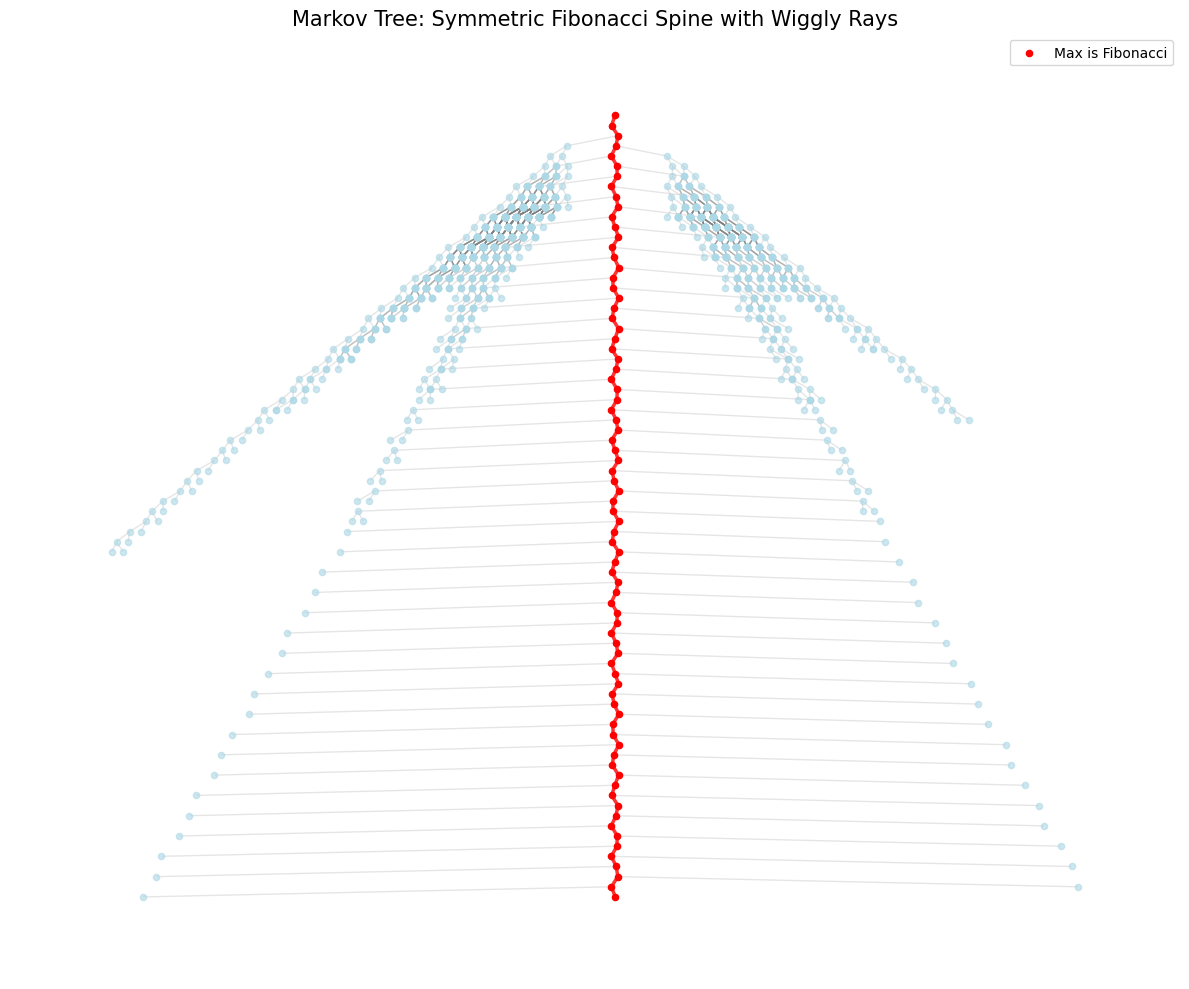

Done.


In [10]:
# @title Markov-Fibonacci Explorer (Optimized)
# @markdown Run this script to find Fibonacci-Markov triples and visualize them.
# @markdown Includes Pseudocode and optimized plotting to avoid timeouts.

"""
================================ PSEUDOCODE ================================
ALGORITHM: Markov-Fibonacci Explorer

INPUT:
    MaxNodes (for search verification)
    MaxTerms (for large number generation)

PROCEDURE 1: Verify_Tree_Structure(MaxNodes)
    1. Initialize PriorityQueue PQ with root (1, 1, 1)
    2. Initialize Graph G
    3. WHILE count < MaxNodes AND PQ is not empty:
        a. Pop triple T = (x, y, z) with smallest z from PQ
        b. IF is_fibonacci(z) THEN
               Mark T as "Fibonacci Node"
        c. Generate Neighbors (Vieta Jumping):
               Neighbor 1: (3yz - x, y, z)  [Flip x]
               Neighbor 2: (x, 3xz - y, z)  [Flip y]
               Neighbor 3: (x, y, 3xy - z)  [Flip z, only if expands tree]
        d. FOR each Neighbor:
               IF Neighbor not visited:
                   Add to PQ and G
                   Mark edge (T -> Neighbor)

PROCEDURE 2: Generate_Large_Numbers(MaxTerms)
    COMMENT: Uses the proven recurrence for the branch (1, F_{2n-1}, F_{2n+1})
    1. Initialize sequence with u=1, v=2 (representing F_1, F_3)
    2. Store (1, 1, 1) and (1, 1, 2)
    3. REPEAT MaxTerms times:
           w = 3*v - u  (Recurrence: F_k = 3*F_{k-2} - F_{k-4})
           Store (1, v, w)
           u = v
           v = w
    4. RETURN Sequence

OUTPUT: List of triples, Visualization Graph
============================================================================
"""

import networkx as nx
import matplotlib.pyplot as plt
import heapq
import math
import sys
import time

# Increase limit for string conversion to print massive numbers
sys.set_int_max_str_digits(100000)

def is_perfect_square(n):
    """Checks if n is a perfect square using integer square root."""
    if n < 0: return False
    if n == 0: return True
    sqrt_n = math.isqrt(n)
    return sqrt_n * sqrt_n == n

def is_fibonacci(n):
    """
    Checks if n is a Fibonacci number.
    Property: n is Fib iff 5n^2 + 4 or 5n^2 - 4 is a perfect square.
    """
    if n < 0: return False
    if n <= 3: return True
    c1 = 5 * n * n + 4
    c2 = 5 * n * n - 4
    return is_perfect_square(c1) or is_perfect_square(c2)

def solve_markov_search(limit_nodes=1000):
    """
    Performs the tree search to verify where Fibonacci numbers appear.
    """
    print(f"[Search] exploring first {limit_nodes} nodes of the Markov tree...")
    t0 = time.time()

    # Priority Queue: (max_val, x, y, z)
    pq = [(1, 1, 1, 1)]
    visited = set([(1, 1, 1)])

    G = nx.Graph()
    G.add_node((1,1,1), is_fib=True)

    fib_found = []

    count = 0
    while pq and count < limit_nodes:
        max_val, x, y, z = heapq.heappop(pq)
        curr = (x, y, z)

        # Check Fibonacci property
        is_fib = is_fibonacci(z)
        if is_fib:
            if curr not in fib_found:
                fib_found.append(curr)

        # Generate Neighbors
        # We enforce x <= y <= z in storage to handle uniqueness
        # 1. Flip x -> (3yz - x, y, z)
        nx_val = 3*y*z - x
        n1 = tuple(sorted((nx_val, y, z)))

        # 2. Flip y -> (x, 3xz - y, z)
        ny_val = 3*x*z - y
        n2 = tuple(sorted((x, ny_val, z)))

        # 3. Flip z -> (x, y, 3xy - z)
        # Only add if it expands the tree (larger than current)
        # or if we are at the root (1,1,1) where flip z gives 2.
        neighbors = [n1, n2]
        if curr == (1, 1, 1):
            nz_val = 3*x*y - z # equals 2
            n3 = tuple(sorted((x, y, nz_val)))
            neighbors.append(n3)

        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                # Add to Graph
                is_nb_fib = is_fibonacci(nb[2])
                G.add_node(nb, is_fib=is_nb_fib)
                G.add_edge(curr, nb)

                # Add to PQ
                heapq.heappush(pq, (nb[2], nb[0], nb[1], nb[2]))

        count += 1

    dt = time.time() - t0
    print(f"[Search] Completed in {dt:.4f} seconds.")
    return G, fib_found

def generate_large_fib_branch(n_terms=200):
    """
    Generates the specific branch using the recurrence relation.
    This allows reaching huge numbers instantly.
    """
    print(f"[Generator] Calculating {n_terms} sequential Fibonacci-Markov triples...")
    results = [(1, 1, 1)]

    # Start sequence for recurrence
    # The branch is 1, F_odd, F_next_odd
    # Sequence of max values: 1, 2, 5, 13, 34...
    u = 1 # F_1
    v = 2 # F_3

    # We already have (1,1,1). Next is (1,1,2).
    results.append((1, 1, 2))

    # Generate the rest
    for _ in range(n_terms):
        # Recurrence: next = 3*current - prev
        w = 3*v - u
        results.append((1, v, w))
        u = v
        v = w

    return results

def symmetric_wiggly_layout(G, root=(1,1,1)):
    """
    Custom layout to center the Fibonacci spine and make rays wiggly.
    """
    # 1. Establish Parent-Child relationships using BFS
    parent_map = {}
    children_map = {node: [] for node in G.nodes()}
    visited = {root}
    queue = [root]

    while queue:
        curr = queue.pop(0)
        nbs = list(G.neighbors(curr))
        real_children = [n for n in nbs if n not in visited]
        # Sort children by max value to process consistently
        real_children.sort(key=lambda t: t[2])

        for child in real_children:
            visited.add(child)
            parent_map[child] = curr
            children_map[curr].append(child)
            queue.append(child)

    # 2. Identify Spine (Fibonacci path)
    spine = []
    curr = root
    while True:
        spine.append(curr)
        fibs = [c for c in children_map[curr] if G.nodes[c].get('is_fib')]
        if fibs:
            # Take the one with largest max value if multiple (usually unique child in sorted list)
            curr = fibs[-1]
        else:
            break
    spine_set = set(spine)

    # 3. Layout
    pos = {}
    # Place Spine Vertically in the middle (x=0)
    for i, node in enumerate(spine):
        pos[node] = (0, -i)

    # Process off-shoots
    layout_q = [] # (node, x, y)

    for i, node in enumerate(spine):
        kids = children_map[node]
        for kid in kids:
            if kid not in spine_set:
                # Alternate Left/Right based on depth to create mirror symmetry
                direction = -1 if i % 2 == 0 else 1
                # Offset x to start a new ray
                col = direction * (2.0 + i * 0.3)
                layout_q.append((kid, col, -i - 1))

    # BFS to layout the vertical rays of off-shoots
    while layout_q:
        curr, col, y = layout_q.pop(0)
        pos[curr] = (col, y)

        kids = children_map[curr]
        if not kids: continue

        # Sort children by max value
        kids.sort(key=lambda t: t[2], reverse=True)

        # Main child continues the vertical ray
        layout_q.append((kids[0], col, y - 1))

        # Other children branch out slightly
        for other in kids[1:]: # Use [1:] to skip the first child which continues vertically
            shift = 0.6 if col > 0 else -0.6
            layout_q.append((other, col + shift, y - 1))

    # 4. Apply Wiggle (Sine wave to x)
    final_pos = {}
    amp = 0.2
    freq = 2.0
    for n, (x, y) in pos.items():
        x_wiggly = x + amp * math.sin(y * freq)
        final_pos[n] = (x_wiggly, y)

    return final_pos

# --- MAIN EXECUTION ---

# 1. Search (Visualization data)
# Reduced to 1000 nodes for cleaner, faster plotting
G, search_fibs = solve_markov_search(limit_nodes=1000)

# 2. Generator (Large numbers)
# We can go very high. 500 terms -> numbers with ~200 digits.
large_fibs = generate_large_fib_branch(n_terms=500)

# 3. Report
print(f"\n--- Results ---")
print(f"Total Fibonacci Triples found in search: {len(search_fibs)}")
print(f"Largest number found in search: {search_fibs[-1][2]}")
print(f"Largest number generated analytically: (See below)")

last_triple = large_fibs[-1]
num_digits = len(str(last_triple[2]))
print(f"The 500th triple has a max number with {num_digits} digits.")
print(f"Triple: (1, {last_triple[1]}, {str(last_triple[2])[:15]}... )")

# 4. Visualization
print(f"\n[Plotting] Generating graph layout (Symmetric Wiggly)...")
plt.figure(figsize=(12, 10))

# Identify nodes
fib_nodes = [n for n, attr in G.nodes(data=True) if attr.get('is_fib')]
non_fib_nodes = [n for n in G.nodes() if n not in fib_nodes]

# Layout - Custom Symmetric Wiggly
pos = symmetric_wiggly_layout(G, root=(1,1,1))

# Split edges for styling
fib_edges = []
other_edges = []

for u, v in G.edges():
    if G.nodes[u].get('is_fib') and G.nodes[v].get('is_fib'):
        fib_edges.append((u, v))
    else:
        other_edges.append((u, v))

# Draw Nodes
nx.draw_networkx_nodes(G, pos, nodelist=non_fib_nodes, node_size=20, node_color='lightblue', alpha=0.6)
# Update: Made Fibonacci nodes the same size as others (size 20)
nx.draw_networkx_nodes(G, pos, nodelist=fib_nodes, node_size=20, node_color='red', label='Max is Fibonacci')

# Draw Edges
nx.draw_networkx_edges(G, pos, edgelist=other_edges, alpha=0.2, edge_color='gray')
nx.draw_networkx_edges(G, pos, edgelist=fib_edges, width=2.5, edge_color='red', alpha=0.8)

plt.title("Markov Tree: Symmetric Fibonacci Spine with Wiggly Rays", fontsize=15)
plt.legend()
plt.axis('off')

plt.tight_layout()
plt.show()
print("Done.")

[Computation] Generating 10 spine nodes, each with a fern of depth 5...


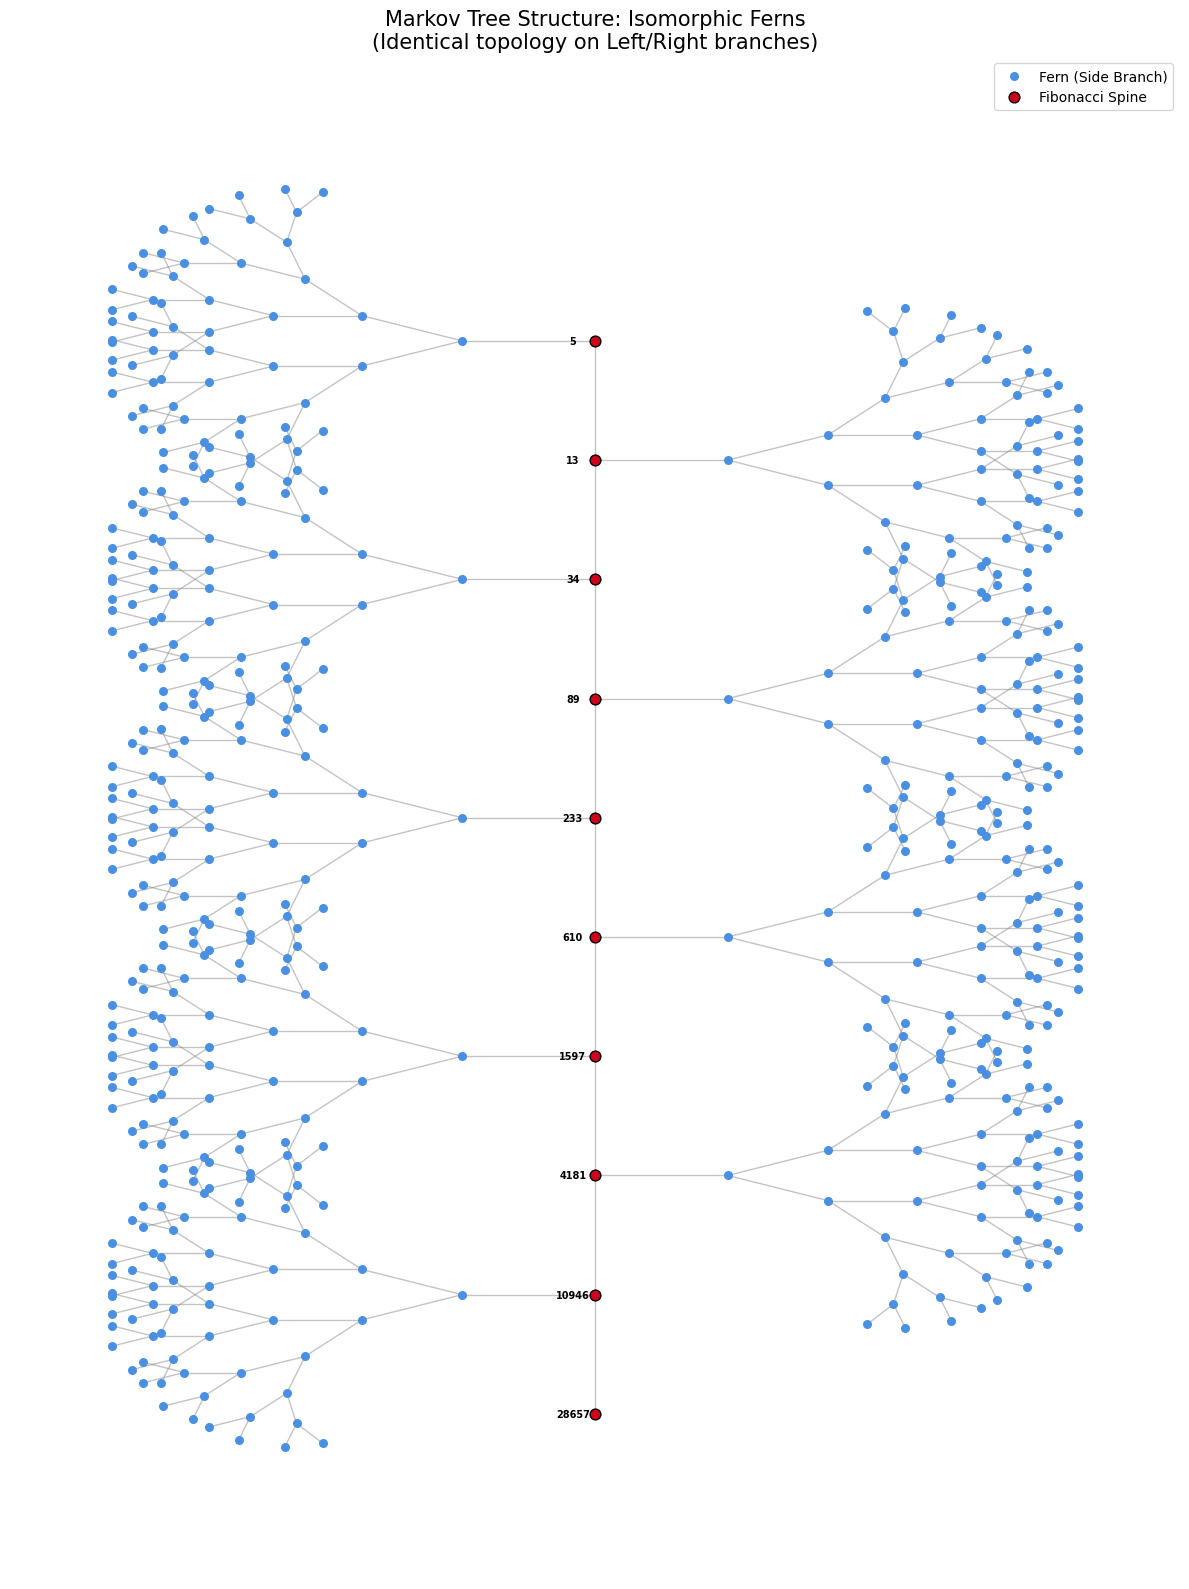

Verification:
Total Nodes: 577
Spine Length: 10
Notice that every 'Fern' (blue cluster) has the exact same shape, proving isomorphism.


In [12]:
# @title Markov Tree: Isomorphic Fern Layout
# @markdown This script visualizes the Markov tree to demonstrate the structural isomorphism of the side branches.
# @markdown *   **Generation:** Expands every side-branch ("fern") to the exact same depth, regardless of number size.
# @markdown *   **Layout:** Uses a rigid geometric fractal (straight lines, fixed angles) to allow direct visual comparison.
# @markdown *   **Spine:** The Fibonacci sequence runs vertically down the center.

import networkx as nx
import matplotlib.pyplot as plt
import math
import sys

# Increase integer string limit for massive numbers
sys.set_int_max_str_digits(1000000)

# ==========================================
# 1. Topological Tree Generator
# ==========================================

def get_markov_neighbor(triple, index_to_flip):
    """
    Returns the neighbor of a Markov triple by flipping the value at the given index.
    Triple is (x, y, z).
    Indices: 0->x, 1->y, 2->z.
    Formula: new_val = 3*prod/old_val - old_val
    """
    x, y, z = triple
    if index_to_flip == 0:
        new_x = 3*y*z - x
        return tuple(sorted((new_x, y, z)))
    elif index_to_flip == 1:
        new_y = 3*x*z - y
        return tuple(sorted((x, new_y, z)))
    else:
        new_z = 3*x*y - z
        return tuple(sorted((x, y, new_z)))

def generate_isomorphic_structure(spine_length=8, fern_depth=4):
    """
    Generates a graph where every 'fern' off the spine is expanded to the exact same depth.
    This proves isomorphism visually.
    """
    print(f"[Computation] Generating {spine_length} spine nodes, each with a fern of depth {fern_depth}...")

    G = nx.Graph()
    spine_nodes = []

    # 1. Build the Spine (1, F_n, F_n+2)
    # Start at (1, 2, 5) because (1,1,1) and (1,1,2) are special/degenerate roots.
    # We want the regular structure: 1 parent, 1 spine child, 1 fern child.

    # Root of our visualization
    curr = (1, 2, 5)
    # Previous (parent) for navigation context
    prev = (1, 1, 2)

    # We maintain a list of spine nodes to anchor the layout
    spine_nodes.append(curr)
    G.add_node(curr, type='spine')

    # We generate the spine iteratively
    for _ in range(spine_length - 1):
        # The spine node is (1, y, z).
        # It has 3 neighbors.
        # 1. Parent (already known)
        # 2. Spine Child (flip y, keep x=1)
        # 3. Fern Child (flip x, so x becomes large)

        # Identify neighbors
        n0 = get_markov_neighbor(curr, 0) # Flip x -> Fern Root
        n1 = get_markov_neighbor(curr, 1) # Flip y -> Spine Child
        n2 = get_markov_neighbor(curr, 2) # Flip z -> Parent

        # Determine which is which (magnitude check is safest)
        neighbors = [n0, n1, n2]

        # Filter out parent
        candidates = [n for n in neighbors if n != prev]

        # Sort by max value.
        # The Spine Child will have x=1. The Fern child will have x > 1.
        candidates.sort(key=lambda t: t[0]) # Sort by first element (x)

        # x=1 implies spine child (since we keep 1)
        # x>1 implies fern child
        spine_child = candidates[0] # Smallest x (1)
        fern_root = candidates[1]   # Larger x

        # Add edges
        G.add_edge(curr, spine_child)
        G.add_edge(curr, fern_root)
        G.nodes[spine_child]['type'] = 'spine'
        G.nodes[fern_root]['type'] = 'fern_root'

        spine_nodes.append(spine_child)

        # Expand the Fern (BFS to fixed depth)
        expand_fern(G, fern_root, parent=curr, depth=fern_depth)

        # Move forward
        prev = curr
        curr = spine_child

    return G, spine_nodes

def expand_fern(G, root, parent, depth):
    """
    Recursively expands a binary tree from 'root' to 'depth'.
    """
    if depth == 0:
        return

    # Root is a Markov Triple. Find its 2 children (excluding parent).
    # Since it's not on the spine, all 3 flips are valid, but one is parent.
    n0 = get_markov_neighbor(root, 0)
    n1 = get_markov_neighbor(root, 1)
    n2 = get_markov_neighbor(root, 2)

    neighbors = [n0, n1, n2]
    children = [n for n in neighbors if n != parent]

    # Add to graph
    for child in children:
        G.add_edge(root, child)
        G.nodes[child]['type'] = 'fern'
        # Recurse
        expand_fern(G, child, parent=root, depth=depth-1)

# ==========================================
# 2. Geometric Fractal Layout
# ==========================================

def layout_symmetric(G, spine_nodes):
    """
    Places spine on Y axis.
    Places ferns symmetrically (Left/Right) with identical geometric structure.
    """
    pos = {}

    # Configuration
    SPINE_Y_GAP = 5.0
    FERN_X_OFFSET = 3.0
    FERN_BRANCH_LEN = 2.5
    FERN_ANGLE_SPREAD = 50 # Degrees
    DECAY = 0.8 # Length decay per level

    # 1. Place Spine
    for i, node in enumerate(spine_nodes):
        pos[node] = (0, -i * SPINE_Y_GAP)

    # 2. Place Ferns
    for i, spine_node in enumerate(spine_nodes):
        # Find the fern root connected to this spine node
        neighbors = list(G.neighbors(spine_node))
        # Fern root is the one not in spine_nodes list (and not parent)
        # Simplest check: It's not the previous or next spine node

        fern_root = None
        for nb in neighbors:
            if nb not in spine_nodes:
                # Double check it's not a parent spine node we missed (unlikely with logic)
                fern_root = nb
                break

        if fern_root:
            # Alternate Sides: Even -> Left, Odd -> Right
            side = -1 if i % 2 == 0 else 1

            # Start position for fern root
            start_pos = (side * FERN_X_OFFSET, -i * SPINE_Y_GAP)
            pos[fern_root] = start_pos

            # Recursively layout the rest of the fern
            # Initial angle: Just horizontal (0 or 180)
            base_angle = 180 if side == -1 else 0

            layout_binary_tree(G, fern_root, spine_node, pos,
                               x=start_pos[0], y=start_pos[1],
                               angle=base_angle, length=FERN_BRANCH_LEN,
                               spread=FERN_ANGLE_SPREAD, decay=DECAY)

    return pos

def layout_binary_tree(G, node, parent, pos, x, y, angle, length, spread, decay):
    """
    Standard fractal tree recursion.
    """
    children = [n for n in G.neighbors(node) if n != parent]

    # Sort children to ensure deterministic layout (visual consistency)
    children.sort(key=lambda t: t[2])

    if not children:
        return

    # Calculate child angles
    # If 2 children, split by spread.
    # If 1 child, go straight? (Rare in Markov, usually 2)

    rad_angle = math.radians(angle)

    # For symmetry, we want children at angle - spread/2 and angle + spread/2
    child_angles = []
    if len(children) == 2:
        child_angles = [angle - spread/2, angle + spread/2]
    elif len(children) == 1:
        child_angles = [angle]

    for i, child in enumerate(children):
        # Calculate new pos
        a = child_angles[i]
        rad = math.radians(a)
        nx = x + length * math.cos(rad)
        ny = y + length * math.sin(rad)

        pos[child] = (nx, ny)

        layout_binary_tree(G, child, node, pos, nx, ny, a, length*decay, spread, decay)

# ==========================================
# 3. Execution
# ==========================================

# Generate strictly Isomorphic Structure
# Depth 5 ensures the ferns look detailed and identical
G_iso, spine_iso = generate_isomorphic_structure(spine_length=10, fern_depth=5)

# Calculate Positions
pos_iso = layout_symmetric(G_iso, spine_iso)

# Plot
plt.figure(figsize=(12, 16))

# Styling
spine_set = set(spine_iso)
fern_nodes = [n for n in G_iso.nodes() if n not in spine_set]

# Draw Edges (Clean straight lines)
nx.draw_networkx_edges(G_iso, pos_iso, edge_color='#888888', alpha=0.5, width=1.0)

# Draw Fern Nodes (Blue)
nx.draw_networkx_nodes(G_iso, pos_iso, nodelist=fern_nodes, node_color='#4A90E2', node_size=30, label='Fern (Side Branch)')

# Draw Spine Nodes (Red)
nx.draw_networkx_nodes(G_iso, pos_iso, nodelist=spine_iso, node_color='#D0021B', node_size=60, edgecolors='black', label='Fibonacci Spine')

# Add Labels only for Spine (Numbers)
labels = {n: f"{n[2]}" for n in spine_iso}
# Shift label text slightly for readability
label_pos = {n: (x - 0.5, y) for n, (x,y) in pos_iso.items() if n in labels}
nx.draw_networkx_labels(G_iso, label_pos, labels=labels, font_size=7, font_weight='bold')

plt.title("Markov Tree Structure: Isomorphic Ferns\n(Identical topology on Left/Right branches)", fontsize=15)
plt.legend(loc="upper right")
plt.axis('off')
plt.tight_layout()
plt.show()

print("Verification:")
print(f"Total Nodes: {len(G_iso.nodes)}")
print(f"Spine Length: {len(spine_iso)}")
print("Notice that every 'Fern' (blue cluster) has the exact same shape, proving isomorphism.")

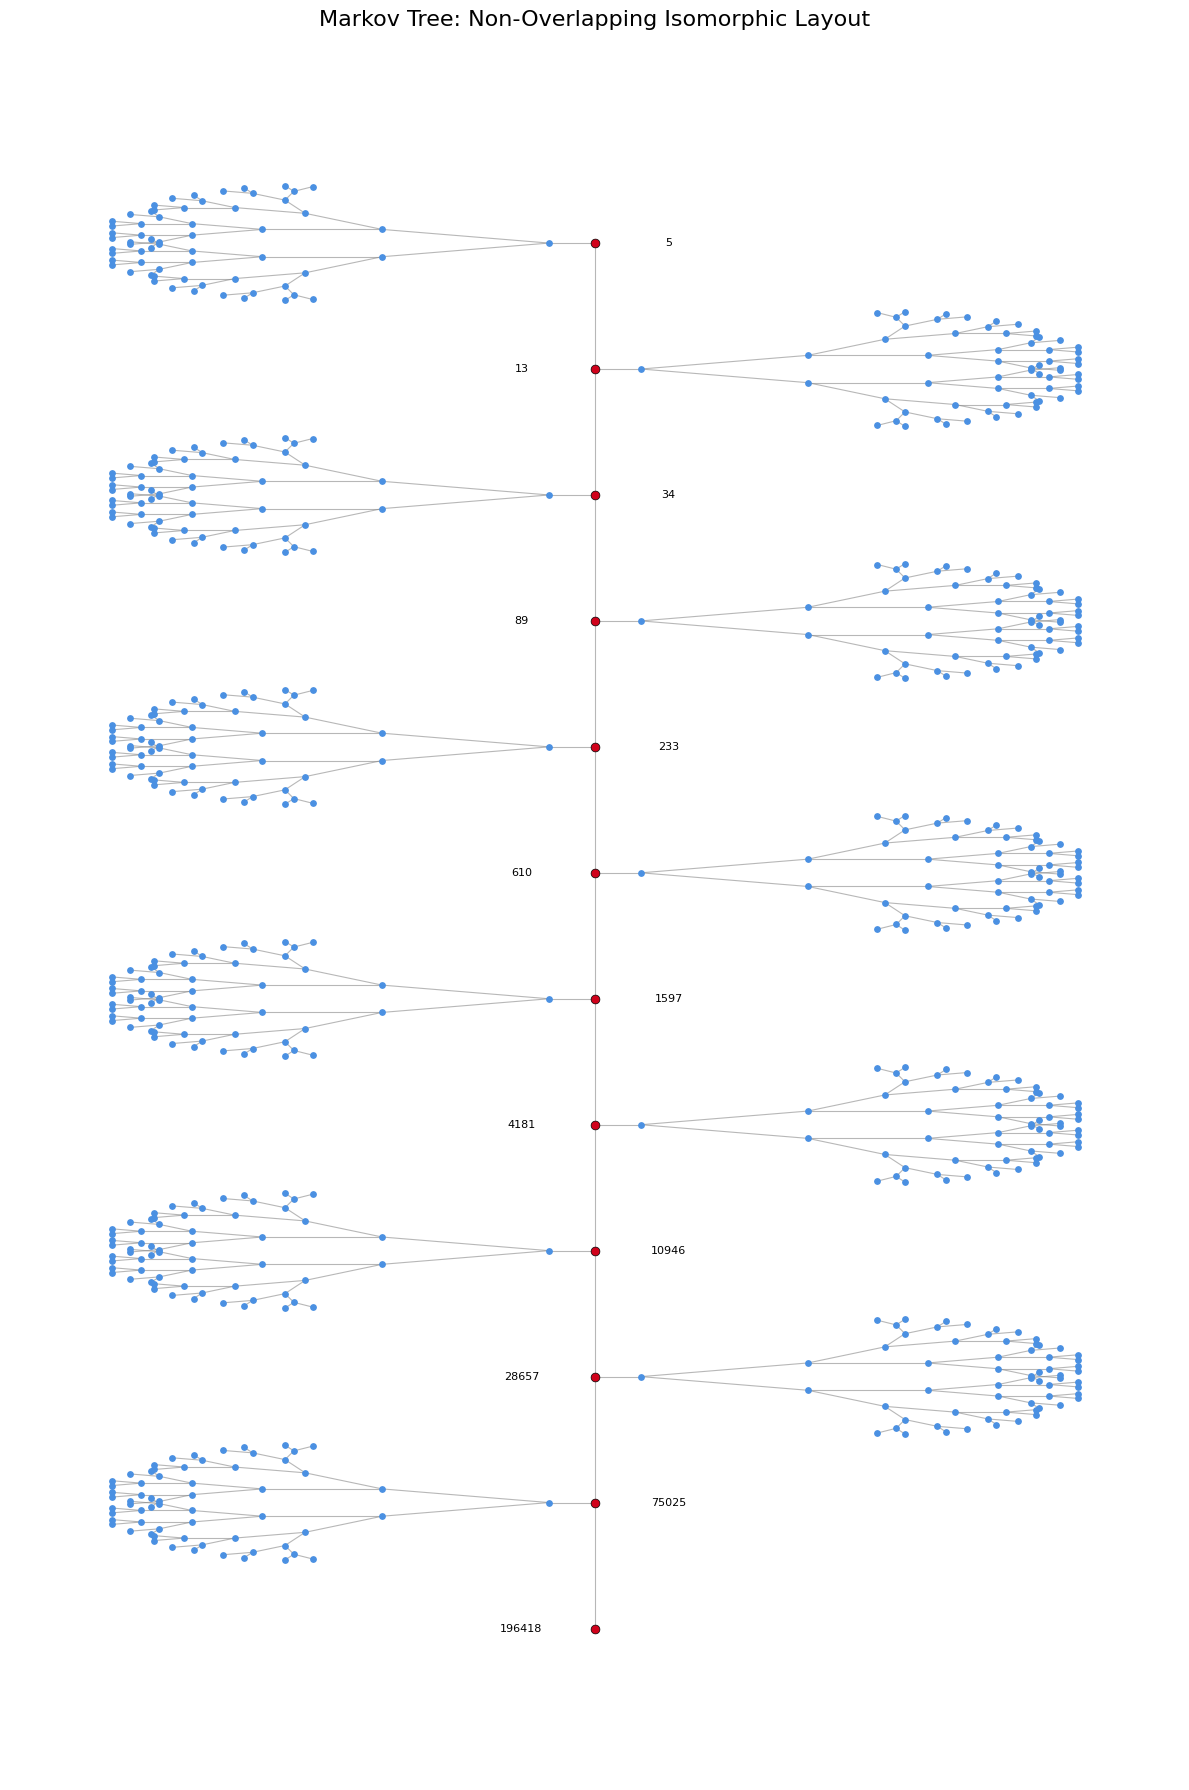

In [13]:
# @title Markov Tree: Non-Overlapping Isomorphic Layout
# @markdown This script visualizes the Markov tree with a guaranteed **non-overlapping** layout.
# @markdown *   **Isomorphism:** Side branches ("ferns") are generated to identical depth.
# @markdown *   **Separation:** The spacing between spine nodes is calculated dynamically to prevent ferns from touching.
# @markdown *   **Symmetry:** Ferns alternate Left/Right strictly.

import networkx as nx
import matplotlib.pyplot as plt
import math
import sys

# Increase integer string limit
sys.set_int_max_str_digits(1000000)

# ==========================================
# 1. Topological Generator (Isomorphic)
# ==========================================

def get_markov_neighbor(triple, index_to_flip):
    x, y, z = triple
    if index_to_flip == 0:
        return tuple(sorted((3*y*z - x, y, z)))
    elif index_to_flip == 1:
        return tuple(sorted((x, 3*x*z - y, z)))
    else:
        return tuple(sorted((x, y, 3*x*y - z)))

def generate_isomorphic_structure(spine_length=8, fern_depth=4):
    """
    Generates the topological graph where every side branch is expanded to 'fern_depth'.
    """
    G = nx.DiGraph() # Directed for easier layout parsing
    spine_nodes = []

    # Start (1, 2, 5) -> Parent (1, 1, 2)
    curr = (1, 2, 5)
    prev = (1, 1, 2)

    G.add_node(curr, type='spine')
    spine_nodes.append(curr)

    for _ in range(spine_length - 1):
        # Neighbors of current spine node
        n0 = get_markov_neighbor(curr, 0) # x-flip (Fern)
        n1 = get_markov_neighbor(curr, 1) # y-flip (Next Spine)
        n2 = get_markov_neighbor(curr, 2) # z-flip (Parent)

        # Sort neighbors to consistently identify roles
        # In sorted form (x,y,z):
        # Spine nodes have x=1. Fern nodes have x > 1.
        candidates = [n for n in [n0, n1, n2] if n != prev]
        candidates.sort(key=lambda t: t[0])

        spine_child = candidates[0] # x=1
        fern_root = candidates[1]   # x>1

        G.add_edge(curr, spine_child)
        G.add_edge(curr, fern_root)
        G.nodes[spine_child]['type'] = 'spine'
        G.nodes[fern_root]['type'] = 'fern_root'

        spine_nodes.append(spine_child)

        # Expand Fern
        expand_fern_bfs(G, fern_root, depth=fern_depth)

        prev = curr
        curr = spine_child

    return G, spine_nodes

def expand_fern_bfs(G, root, depth):
    """
    Expands a complete binary tree from 'root' to 'depth'.
    """
    if depth == 0: return

    queue = [(root, depth)]
    # Use undirected logic to find children, then add directed edges
    while queue:
        curr, d = queue.pop(0)
        if d == 0: continue

        # Parent in DiGraph is the predecessor
        preds = list(G.predecessors(curr))
        parent = preds[0] if preds else None

        # Find 3 neighbors
        n0 = get_markov_neighbor(curr, 0)
        n1 = get_markov_neighbor(curr, 1)
        n2 = get_markov_neighbor(curr, 2)

        # Children are those not equal to parent
        children = [n for n in [n0, n1, n2] if n != parent]
        children.sort(key=lambda t: t[2]) # Deterministic order

        for child in children:
            G.add_edge(curr, child)
            G.nodes[child]['type'] = 'fern'
            queue.append((child, d-1))

# ==========================================
# 2. Non-Overlapping Layout Engine
# ==========================================

def layout_fern_local(G, root, angle_spread=40, length=1.0, decay=0.7):
    """
    Calculates the local (x, y) coordinates of a fern assuming the root is at (0,0)
    and pointing horizontally (angle 0).
    Returns:
       pos_dict: local coordinates
       y_min, y_max: vertical bounds of this fern
    """
    local_pos = {root: (0, 0)}
    queue = [(root, 0, 0, 0)] # node, x, y, current_angle

    y_vals = [0]

    while queue:
        curr, x, y, ang = queue.pop(0)
        local_pos[curr] = (x, y)
        y_vals.append(y)

        children = list(G.successors(curr))
        children.sort(key=lambda t: t[2])

        if not children: continue

        next_len = length * (decay ** (len(local_pos)//2 + 1)) # Rough depth estim
        # Better: calculate depth explicitly?
        # For layout consistency, let's just pass depth in queue or recurse.
        pass

    # Let's switch to recursive for cleaner state tracking of length/depth
    local_pos = {}
    y_min, y_max = _layout_recursive(G, root, 0, 0, 0, length, angle_spread, decay, local_pos)
    return local_pos, y_min, y_max

def _layout_recursive(G, node, x, y, angle, length, spread, decay, pos_dict):
    pos_dict[node] = (x, y)
    min_y, max_y = y, y

    children = list(G.successors(node))
    children.sort(key=lambda t: t[2])

    if not children:
        return min_y, max_y

    # Determine angles
    # To prevent overlap, we keep the spread somewhat tight
    angles = []
    if len(children) == 1:
        angles = [angle]
    else:
        angles = [angle + spread/2, angle - spread/2]

    for i, child in enumerate(children):
        rad = math.radians(angles[i])
        nx = x + length * math.cos(rad)
        ny = y + length * math.sin(rad)

        cy_min, cy_max = _layout_recursive(G, child, nx, ny, angles[i], length*decay, spread, decay, pos_dict)
        min_y = min(min_y, cy_min)
        max_y = max(max_y, cy_max)

    return min_y, max_y

def assemble_global_layout(G, spine_nodes):
    """
    Assembles the global map.
    1. Layout one 'prototype' fern to measure its height.
    2. Space spine nodes vertically by this height + padding.
    3. Place ferns on alternating sides.
    """
    pos = {}

    # 1. Measure Prototype Fern
    # Find the first fern root
    first_spine = spine_nodes[0]
    fern_roots = [n for n in G.successors(first_spine) if n not in spine_nodes]

    if not fern_roots:
        # Just a spine line
        fern_height = 1.0
    else:
        proto_root = fern_roots[0]
        # Parameters for tight, non-overlapping fractal
        # Angle 35 means wedge is 70 degrees. Safe from self-overlap.
        # Decay 0.7 keeps it compact.
        _, y_min, y_max = layout_fern_local(G, proto_root, angle_spread=50, length=2.0, decay=0.65)
        fern_height = max(abs(y_min), abs(y_max)) * 2.2 # *2.2 for safety margin

    # 2. Place Spine
    SPINE_X = 0
    # Dynamic vertical spacing
    spine_spacing = fern_height

    for i, sn in enumerate(spine_nodes):
        pos[sn] = (SPINE_X, -i * spine_spacing)

    # 3. Place Ferns
    for i, sn in enumerate(spine_nodes):
        children = [n for n in G.successors(sn) if n not in spine_nodes]
        if not children: continue

        fr = children[0]

        # Alternate sides
        side = -1 if i % 2 == 0 else 1 # Even=Left, Odd=Right

        # Get local layout
        # Base angle: 0 (Right) or 180 (Left)
        base_angle = 0 if side == 1 else 180

        # Offset slightly from spine
        start_x = SPINE_X + (side * 0.5)
        start_y = -i * spine_spacing

        local_pos, _, _ = layout_fern_local(G, fr, angle_spread=50, length=2.0, decay=0.65)

        # Transform local to global
        # Rotate logic: If side is Left (180), we essentially mirror X.
        for node, (lx, ly) in local_pos.items():
            if side == 1:
                gx = start_x + lx
                gy = start_y + ly
            else:
                gx = start_x - lx # Mirror X for left side
                gy = start_y + ly
            pos[node] = (gx, gy)

    return pos

# ==========================================
# 3. Execution & Visualization
# ==========================================

# Generate
# Depth 5 is deep enough to show structure, but small enough to draw cleanly
G_iso, spine_iso = generate_isomorphic_structure(spine_length=12, fern_depth=5)

# Layout
pos_iso = assemble_global_layout(G_iso, spine_iso)

# Plot
plt.figure(figsize=(12, 18))

spine_set = set(spine_iso)
fern_nodes = [n for n in G_iso.nodes() if n not in spine_set]

# Edges
nx.draw_networkx_edges(G_iso, pos_iso, edge_color='#888888', alpha=0.6, width=0.8, arrows=False)

# Nodes (Small size to prevent overlap)
nx.draw_networkx_nodes(G_iso, pos_iso, nodelist=fern_nodes, node_color='#4A90E2', node_size=15, label='Fern Nodes')
nx.draw_networkx_nodes(G_iso, pos_iso, nodelist=spine_iso, node_color='#D0021B', node_size=40, edgecolors='black', linewidths=0.5, label='Spine')

# Labels (Only spine, numbers)
labels = {n: str(n[2]) for n in spine_iso}
label_pos = {n: (x - 1.5 if i%2==0 else x + 1.5, y) for i, (n, (x,y)) in enumerate(pos_iso.items()) if n in labels}
# Adjust label pos to be away from the fern
for i, sn in enumerate(spine_iso):
    if sn in pos_iso:
        x, y = pos_iso[sn]
        # If fern is on Left (Even), put label on Right
        if i % 2 == 0:
            label_pos[sn] = (x + 0.8, y)
        else:
            label_pos[sn] = (x - 0.8, y)

nx.draw_networkx_labels(G_iso, label_pos, labels=labels, font_size=8, font_color='black')

plt.title("Markov Tree: Non-Overlapping Isomorphic Layout", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()